In [1]:
source("helper.R")
data_ori <- as.data.frame(read_csv("data/weighted_priceIF2404_0317_417.csv"))


Loading required package: Matrix



Warning message in file(con, "r"):
“URL 'https://inla.r-inla-download.org/VERSIONS': Timeout of 2 seconds was reached”
This is INLA_25.06.07 built 2025-06-11 18:54:45 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


This is rSPDE 2.5.1
- See https://davidbolin.github.io/rSPDE for vignettes and manuals.

Rows: 4664 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): close
dttm (1): raw.timeindex

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column type

In [2]:
logpt<-log(data_ori$close)
logreturn <-logpt[2:length(logpt)]-logpt[1:(length(logpt)-1)]
date <- as.POSIXct(as.character(data_ori$raw.timeindex[1:(length(data_ori$raw.timeindex)-1)]), format = "%Y-%m-%d %H:%M:%S")


In [3]:
date_timeindex<-as.numeric(date) 
date_timeindex <- (date_timeindex - min(date_timeindex))/86400 ## 1 day = 86400 seconds



In [25]:
q_low  <- quantile(logreturn, 0.002, na.rm = TRUE)
q_high <- quantile(logreturn, 0.998, na.rm = TRUE)

logreturn <- ifelse(
  logreturn >= q_low & logreturn <= q_high,
  logreturn,
  0
)

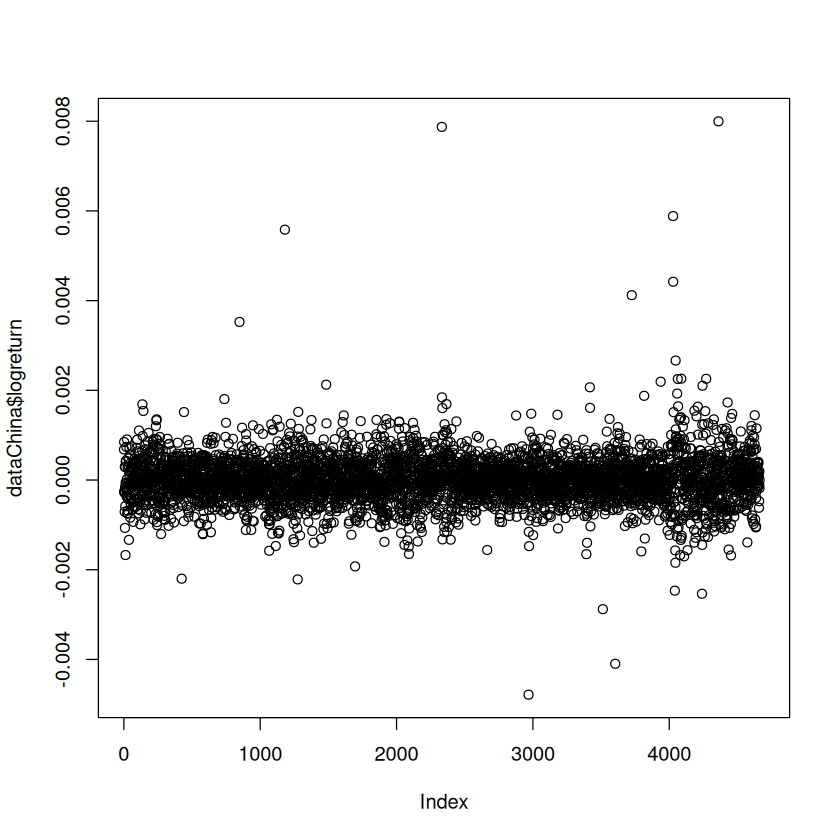

In [4]:


dataChina = data.frame(logreturn = logreturn, times = date_timeindex)
dataChina <- rbind(dataChina, data.frame(logreturn = NA, times = max(date_timeindex):(max(date_timeindex)+31)))
mesh <- fm_mesh_1d(dataChina$times)




data=dataChina


par(bg = "white") 
plot(dataChina$logreturn)

In [5]:
max_idx <- which.max(dataChina$logreturn)
max_time <- data_ori$raw.timeindex[max_idx]
max_value <- dataChina$logreturn[max_idx]

# 最小值
min_idx <- which.min(dataChina$logreturn)
min_time <- data_ori$raw.timeindex[min_idx]
min_value <- dataChina$logreturn[min_idx]

cat("最大值:", max_value, "时间:", max_time, "\n")
cat("最小值:", min_value, "时间:", min_time, "\n")

最大值: 0.00799704 时间: 1713267000 
最小值: -0.004785161 时间: 1712156400 


In [6]:
summary(data)

   logreturn             times       
 Min.   :-0.004785   Min.   : 0.000  
 1st Qu.:-0.000292   1st Qu.: 7.079  
 Median :-0.000014   Median :17.010  
 Mean   : 0.000000   Mean   :16.914  
 3rd Qu.: 0.000287   3rd Qu.:26.172  
 Max.   : 0.007997   Max.   :64.228  
 NA's   :32                          

In [ ]:
rspde.order=2
prior.range.nominal=0.5
prior.std.dev.nominal=0.1
OU_model <- rspde.matern(mesh = mesh,parameterization="matern",rspde.order=rspde.order,prior.range.nominal=prior.range.nominal,prior.std.dev.nominal=prior.std.dev.nominal)
formula_OU <-  logreturn ~ -1 + Intercept(1)+ field(times, model = OU_model)
fit<-bru(formula_OU, family="stochvol", data = data)
result_fit<- rspde.result(fit, "field", OU_model, parameterization="matern")
print(fit$mlik[2])
summary(result_fit)

[1] 29086.13


,mean,sd,0.025quant,0.5quant,0.975quant,mode
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
std.dev,0.780284,0.157412,0.5179560,0.764196,1.13424,0.7321840
range,0.740696,0.286894,0.3289320,0.690920,1.44148,0.6009880
nu,0.341277,0.309033,0.0228979,0.241626,1.18176,0.0597681
